In [2]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.data import shepp_logan_phantom
from warnings import filterwarnings
import torch
import torchkbnufft as tkbn
from scipy.optimize import curve_fit

In [3]:
def create_image(echo_time,fov_x,fov_y,t1_myelin, t1_wm, t2_myelin, t2_wm, t2_star_myelin, t2_star_wm, inv_time):
    #res in cm
    res = 0.1
    
    pixels_x = int(fov_x/res)
    pixels_y = int(fov_y/res)
    pixels = pixels_x*pixels_y
    #print("pixels_x",pixels_x)
    
    image = np.ones((pixels_x, pixels_y))
    
    mxy_myelin = (1-2*np.exp(-(inv_time/t1_myelin)))*np.exp(-(echo_time/t2_star_myelin))
    mxy_wm = (1-2*np.exp(-(inv_time/t1_wm)))*np.exp(-(echo_time/t2_star_wm))
    mxy_mixed = 0.5*((1-2*np.exp(-(inv_time/t1_wm)))*np.exp(-(echo_time/t2_star_wm))) + 0.5*((1-2*np.exp(-(inv_time/t1_myelin)))*np.exp(-(echo_time/t2_star_myelin)))
    
    #print(mxy_myelin)
    #print(mxy_wm)
    #print(mxy_mixed)
    
    outer_square_size = int(1.0 * pixels_x) 
    middle_square_size = int(0.6 * pixels_x)
    inner_square_size = int(0.25 * pixels_x)  
    
    # Calculate starting and ending indices for each square to center them
    outer_start = (pixels_x - outer_square_size) // 2
    outer_end = outer_start + outer_square_size
    
    middle_start = (pixels_x - middle_square_size) // 2
    middle_end = middle_start + middle_square_size
    
    inner_start = (pixels_x - inner_square_size) // 2
    inner_end = inner_start + inner_square_size
    
    # Define the intensity values for each section
    # Outermost square (100% WM - white, intensity = 1)
    image[outer_start:outer_end, outer_start:outer_end] = mxy_wm  # 100% WM
    
    # Middle square (50/50 of WM and myelin - medium gray)
    image[middle_start:middle_end, middle_start:middle_end] = mxy_mixed  # 50/50 of WM and myelin (gray)
    
    # Innermost square (100% myelin - black, intensity = 0)
    image[inner_start:inner_end, inner_start:inner_end] = mxy_myelin  # 100% myelin (black)
    
    
    # # Display the image using matplotlib
    # plt.imshow(image, cmap='gray', interpolation='nearest')
    # plt.axis('off')  # Turn off axis
    # plt.colorbar()
    # plt.show()

    
    
    f_image = np.fft.fft2(image)
    
    fft_image_shifted = np.fft.fftshift(f_image)  # Shift the zero-frequency component to the center
    
    # Compute the magnitude spectrum
    magnitude_spectrum = np.log(np.abs(fft_image_shifted) + 1)  # Log to enhance visibility
    
    # Plot the original image and its FFT magnitude spectrum
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("FFT Magnitude Spectrum - Log")
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    return image,pixels_x,pixels_y

In [4]:
def sample(image,nspokes,num_samples_per_ray,pixels_x,pixels_y):
    im_size = image.shape
    grid_size = (tuple(int(dim * 2) for dim in im_size))
    
    filterwarnings("ignore") # ignore floor divide warnings
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")


    # convert the phantom to a tensor and unsqueeze coil and batch dimension
    image_t = torch.tensor(image).to(device).unsqueeze(0).unsqueeze(0)
    #print('image shape: {}'.format(image_t.shape))

    #res in mm and pixels
    res_mm = 0.5
    max_radii = 0.5/res_mm
    #print(max_radii)
    nspokes = int(2*np.pi*max_radii*pixels_x) # Number of rays
    #nspokes = 8
    num_samples_per_ray = int(max_radii*pixels_x) # Number of samples per ray
    #print(nspokes)
    # Initialize an empty k-space list to store sampled points
    k_space = np.zeros((nspokes * num_samples_per_ray,), dtype=complex)
    
    # Create radial k-space sampling points (rays)
    angles = np.linspace(0, 2 * np.pi, nspokes, endpoint=False)  # Angle of the rays
    radii = np.linspace(0, max_radii, num_samples_per_ray)  # Radial distance (from the center)
    #print(radii)
    #print(angles)
    
    
    # Flatten the image for efficient computation
    image_flattened = image.flatten()
    
    # Loop over rays to calculate Fourier coefficients
    index = 0
    kx_values = []
    ky_values = []
    for angle in angles:
        for radius in radii:
            # Calculate the kx, ky coordinates for each sampled point
            kx = radius * np.cos(angle)  # x-component in frequency domain
            ky = radius * np.sin(angle)  # y-component in frequency domain
    
            # Store kx and ky for density compensation
            kx_values.append(kx)
            ky_values.append(ky)
            
            # Compute the Fourier coefficient for this (kx, ky)
            #k_space[index] = np.sum(image_flattened * np.exp(-1j * 2 * np.pi * (kx * x_grid.flatten() / pixels_x + ky * y_grid.flatten() / pixels_y)))
            index += 1
    
    # Convert kx_values and ky_values to numpy arrays
    kx_values = np.array(kx_values)
    ky_values = np.array(ky_values)
    
    ktraj = np.stack((ky_values.flatten(), kx_values.flatten()), axis=0)
    #print(ktraj.shape)
    
    # # Visualize the radial k-space sampling points (this shows the rays)
    # plt.figure(figsize=(6, 6))
    # for angle in angles:
    #     x_vals = np.linspace(0, max_radii * np.cos(angle), num_samples_per_ray)
    #     y_vals = np.linspace(0, max_radii * np.sin(angle), num_samples_per_ray)
    #     plt.plot(x_vals, y_vals, 'b.', markersize=1)
    # plt.title('Radial k-space Trajectory')
    # plt.xlabel('kx')
    # plt.ylabel('ky')
    # plt.axis()
    # plt.grid(True)
    
    # # Adjust the axis limits to provide padding for text
    # padding = 0.5 * max_radii  # 10% of max_radii for padding
    # plt.xlim(-max_radii - padding, max_radii + padding)
    # plt.ylim(-max_radii - padding, max_radii + padding)
    
    # # Plot markers on the axes at kmax and -kmax
    # plt.plot([max_radii, -max_radii], [0, 0], 'ro', label='kx markers')  # Markers along x-axis
    # plt.plot([0, 0], [max_radii, -max_radii], 'ro', label='ky markers')  # Markers along y-axis
    
    # # Add text labels near the markers with offsets
    # text_offset = 0.05 * max_radii  # Offset for the text relative to the marker
    # plt.text(max_radii + text_offset, 0, 'k x,max', color='red', fontsize=10, ha='left', va='center')  # x-axis positive
    # plt.text(-max_radii - text_offset, 0, '-k x,max', color='red', fontsize=10, ha='right', va='center')  # x-axis negative
    # plt.text(0, max_radii + text_offset, 'k y,max', color='red', fontsize=10, ha='center', va='bottom')  # y-axis positive
    # plt.text(0, -max_radii - text_offset, '-k y,max', color='red', fontsize=10, ha='center', va='top')  # y-axis negative
    
    # plt.show()
    #print(ktraj)

    # convert k-space trajectory to a tensor
    ktraj = torch.tensor(ktraj).to(device)
    #print('ktraj shape: {}'.format(ktraj.shape))

    # create NUFFT objects, use 'ortho' for orthogonal FFTs
    nufft_ob = tkbn.KbNufft(
        im_size=im_size,
        grid_size=grid_size,
    ).to(image_t)
    adjnufft_ob = tkbn.KbNufftAdjoint(
        im_size=im_size,
        grid_size=grid_size,
    ).to(image_t)



    # # plot the kernel
    # fig, axs = plt.subplots(1, 2)
    # axs.flat[0].plot(np.real(nufft_ob.table_0.cpu().numpy()))
    # axs.flat[1].plot(np.imag(nufft_ob.table_0.cpu().numpy()))
        
    # plt.show()


    # Convert image_t to complex if it's real (with last dimension not equal to 2)
    if image_t.ndimension() == 3 and image_t.shape[-1] != 2:  # Real input
        print("Converting real image to complex...")
        image_t = torch.stack([image_t, torch.zeros_like(image_t)], dim=-1)  # Convert to complex
    
    # If it's real, convert it to complex
    if image_t.dtype != torch.complex128:
        #print("Converting image to complex dtype...")
        image_t = image_t.to(torch.complex128)  # Convert to complex type
    
    # Now pass the image to the nufft_ob function
    kdata = nufft_ob(image_t, ktraj)
    # calculate k-space data
    kdata = nufft_ob(image_t, ktraj)
    
    # add some noise (robustness test) Gaussian noise
    siglevel = torch.abs(kdata).mean()
    kdata = kdata + (siglevel/5) * torch.randn(kdata.shape).to(kdata)

    
    # plot the k-space data on log-scale
    # kdata_numpy = np.reshape(kdata.cpu().numpy(), (nspokes,num_samples_per_ray))
    # plt.imshow(np.log10(np.absolute(kdata_numpy)))
    # plt.gray()
    # plt.title('k-space data, log10 scale')
    # plt.show()


    # adjnufft back
    # method 1: no density compensation (blurry image)
    image_blurry = adjnufft_ob(kdata, ktraj)
    
    # method 2: use density compensation
    dcomp = tkbn.calc_density_compensation_function(ktraj=ktraj, im_size=im_size)
    image_sharp = adjnufft_ob(kdata * dcomp, ktraj)



    # show the images
    image_blurry_numpy = np.squeeze(image_blurry.cpu().numpy())
    
    image_sharp_numpy = np.squeeze(image_sharp.cpu().numpy())
    
    #print(image_sharp_numpy.shape)
    #print(image.shape)
    
    diff_image = np.abs(image_sharp - image)
    diff_image = np.squeeze(diff_image)
    
    # plt.figure(0)
    # plt.imshow(np.absolute(image_blurry_numpy))
    # plt.gray()
    # plt.colorbar()
    # plt.title('blurry image')
    
    # plt.figure(1)
    # plt.imshow(np.absolute(image_sharp_numpy))
    # plt.gray()
    # plt.colorbar()
    # plt.title('sharp image (with Pipe dcomp)')
    
    # plt.figure(2)
    # plt.imshow(np.absolute(image))
    # plt.gray()
    # plt.colorbar()
    # plt.title('Original Image')
    
    # plt.figure(3)
    # plt.imshow(diff_image, cmap='hot')
    # plt.colorbar()
    # plt.title('Difference Image')
    
    # plt.show()
    return image_sharp_numpy


In [5]:
echo_time = 5e-5
#fov in cm
fov_x = 25
fov_y = fov_x
# Reset parameters for radial k-space sampling
#nspokes = int(np.pi*pixels_x*fov_x)+1 # Number of rays
nspokes = 500
num_samples_per_ray = 300 # Number of samples per ray
t1_myelin = 4.0e-1 
t1_wm = 8.5e-1      
t2_myelin = 5.0e-2  
t2_wm = 5.0e-2     
t2_star_myelin = 3.0e-2  
t2_star_wm = 7.0e-2    
inv_time = np.log(2)*t1_wm
    

pixels_x 250


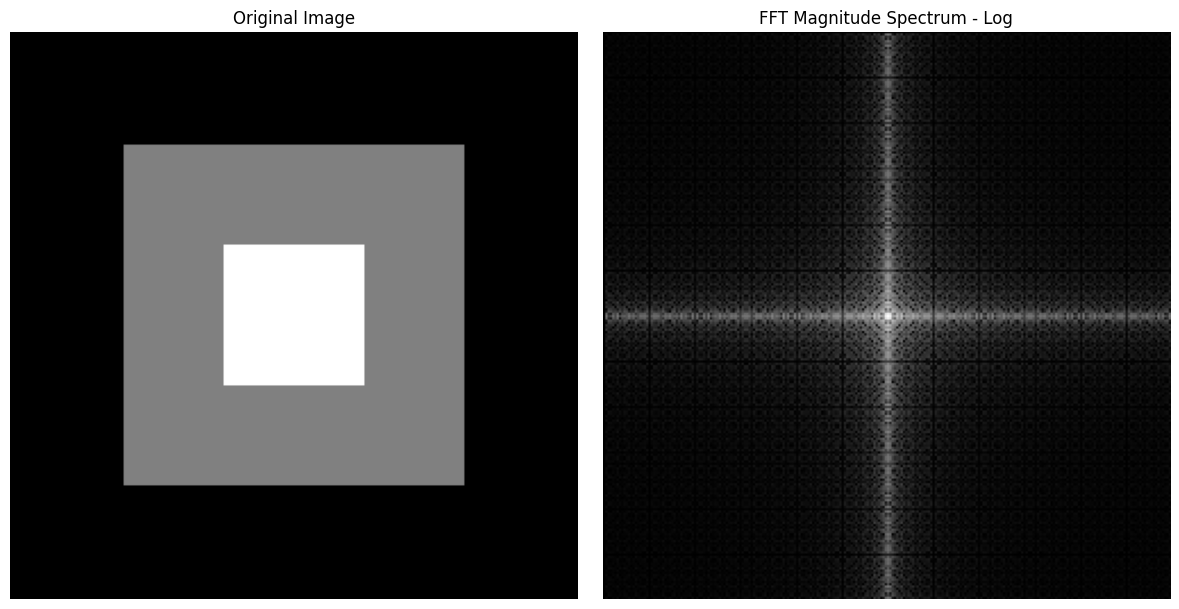

In [121]:
image,pixels_x,pixels_y = create_image(echo_time,fov_x,fov_y,t1_myelin, t1_wm, t2_myelin, t2_wm, t2_star_myelin, t2_star_wm, inv_time)
reconstructed_image = sample(image,nspokes,num_samples_per_ray,pixels_x,pixels_y)

In [122]:
avg_t2_star = np.average(np.abs(reconstructed_image))
print(avg_t2_star)

1978.3358514060467


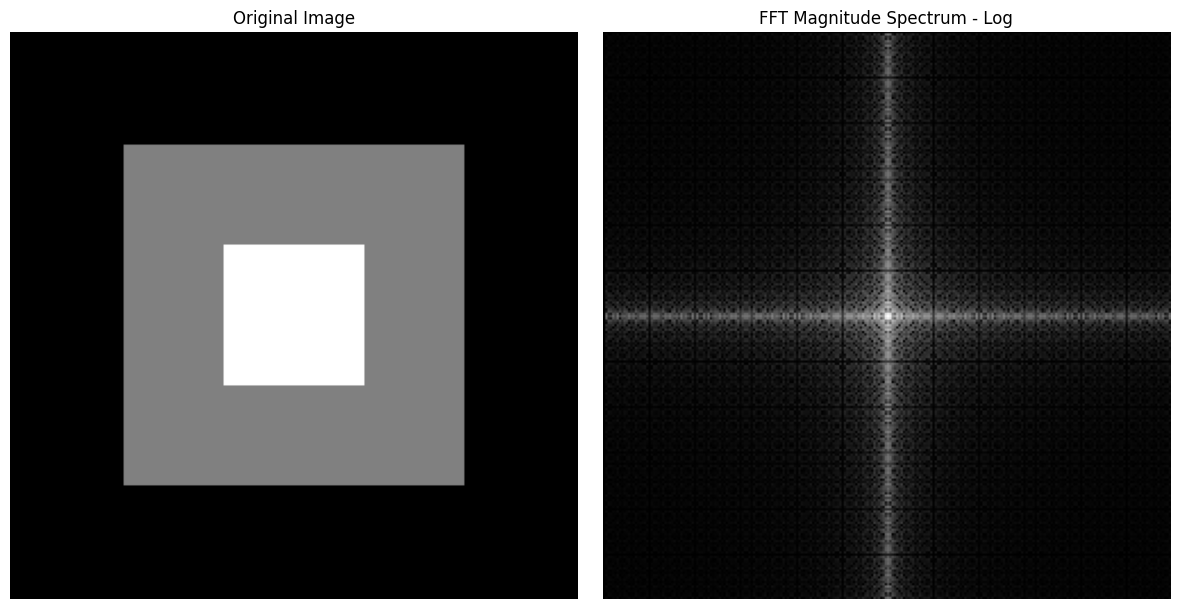

Simulating Data Collection for 4e-05
Simulating Data Collection for 8e-05
Simulating Data Collection for 0.0004
Simulating Data Collection for 0.0008
Simulating Data Collection for 0.004
Simulating Data Collection for 0.008


In [43]:
echo_times = [4e-5,8e-5,4e-4,8e-4,4e-3,8e-3]
images = []

image,pixels_x,pixels_y = create_image(echo_time,fov_x,fov_y,t1_myelin, t1_wm, t2_myelin, t2_wm, t2_star_myelin, t2_star_wm, inv_time)

for echo_time in echo_times:
    print("Simulating Data Collection for",echo_time)
    reconstructed_image = sample(image,nspokes,num_samples_per_ray,pixels_x,pixels_y)
    images.append(np.abs(reconstructed_image))

    

In [44]:
images = np.array(images)
print(images)
print(images[0].shape)
echo_times = np.array(echo_times)

[[[481.3048184  500.1894578  504.0575401  ... 342.79146858 376.03101348
   439.99283175]
  [442.44601976 472.64276043 490.09887898 ... 364.1611631  409.32439639
   452.88035323]
  [395.14627987 422.54213076 446.7165852  ... 371.24758924 416.52801729
   441.26971135]
  ...
  [427.5660493  435.40220912 417.09886471 ... 440.0660729  403.76064347
   371.37788922]
  [442.64435745 440.14002577 416.40316829 ... 459.92641314 439.6773684
   415.17209132]
  [488.83536036 452.73815226 410.10554545 ... 485.78248347 482.77418902
   469.29562079]]

 [[311.27186651 354.97774977 408.4055915  ... 283.69917145 273.92954608
   347.21854387]
  [400.62831486 438.43835756 471.95912926 ... 178.74378425 189.62641465
   301.96387361]
  [470.93690751 494.23840784 510.08663598 ... 126.07857453 157.14936654
   286.19897516]
  ...
  [440.15262107 327.29308101 203.88835906 ... 495.28913901 499.61329707
   492.06036658]
  [430.6166488  285.13634626 156.9869432  ... 497.49082643 503.00202246
   486.86119082]
  [446.7

In [45]:
def fit_curve(pixel_points):
    # Define the T2* decay function
    def t2_star_decay(te, s0, t2_star):
        """
        T2* decay model: S(TE) = S0 * exp(-TE / T2*)
        """
        return s0 * np.exp(-te / t2_star)
    
    signal_values = pixel_points
    
    # Fit the data to the T2* decay model
    initial_guess = [1000, 30e-3]  # Initial guess for [S0, T2*] (e.g., S0=1000, T2*=30 ms)
    params, covariance = curve_fit(t2_star_decay, echo_times, signal_values, p0=initial_guess)
    
    # Extract the fitted parameters
    s0_fitted, t2_star_fitted = params
    
    # Generate the fitted signal curve
    fitted_signal = t2_star_decay(echo_times, s0_fitted, t2_star_fitted)
    
    # # Plot the data and the fitted curve
    # plt.figure(figsize=(8, 6))
    # plt.scatter(echo_times * 1e3, signal_values, label='Data', color='red')  # Convert TE back to ms for display
    # plt.plot(echo_times * 1e3, fitted_signal, label=f'Fitted Curve (T2* = {t2_star_fitted*1e3:.2f} ms)', color='blue')
    # plt.xlabel('Echo Time (TE) [ms]')
    # plt.ylabel('Signal Intensity')
    # plt.title('Fitting Data to T2* Decay Curve')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    
    # # Output fitted T2* value
    # print(f"Fitted T2* value: {t2_star_fitted * 1e3:.2f} ms")
    return t2_star_fitted

In [46]:
pixels_over_time = np.empty((pixels_y, pixels_x), dtype=object)
print(pixels_over_time.shape)
for row in range(pixels_y):
    for col in range(pixels_x):
        pixels_over_time[row, col] = []
        
for image in range(0,len(echo_times)):
    for row in range (0,pixels_y):
        for col in range (0,pixels_x):
            pixels_over_time[row][col].append(images[image][row][col])
            
print(pixels_over_time[0][0])        


(250, 250)
[np.float64(481.3048183967647), np.float64(311.27186650960596), np.float64(249.74015499616888), np.float64(437.1820810936586), np.float64(333.8161528099214), np.float64(499.345906837047)]


In [47]:
pixel_t2 = np.zeros((pixels_y,pixels_x))
for row in range (pixels_y):
    for col in range (pixels_x):
        pixel_t2[row][col] = fit_curve(pixels_over_time[row][col])

print(pixel_t2)        

[[2.62224215e+05 2.50173353e+05 1.21796476e+06 ... 4.17695044e+05
  6.60730486e+05 1.81786689e+05]
 [5.59184077e+04 1.24756709e-01 8.89580044e-02 ... 6.66997065e+05
  2.17553443e+05 2.19850324e+04]
 [3.29677366e-02 2.25174225e-02 2.51373911e-02 ... 3.97101018e+05
  2.89185084e+05 2.10706538e+05]
 ...
 [3.97255279e+04 1.41947307e+05 2.58567564e+05 ... 2.10350096e-02
  1.59664728e-02 1.47804843e-02]
 [7.08381452e-02 3.41204754e+05 2.56532096e+05 ... 4.31378631e-02
  2.47303600e-02 2.20848952e-02]
 [2.90435857e-02 1.15288826e+05 7.96119599e+05 ... 1.20133190e+00
  8.74215880e-02 1.23654302e-01]]


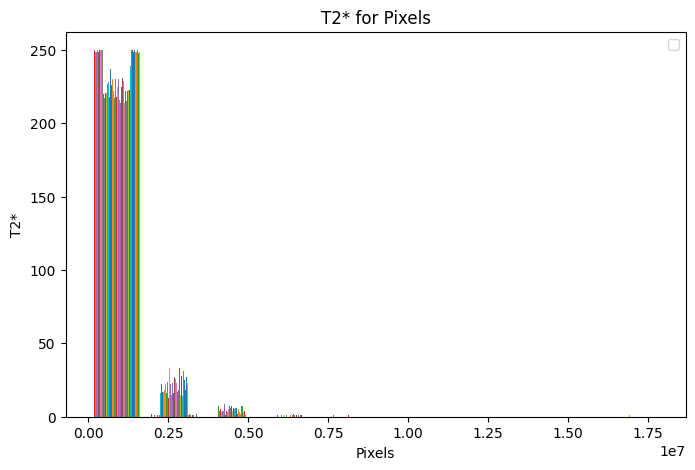

In [49]:
# Plot Echo Times vs Signal for the example pixel
plt.figure(figsize=(8, 5))
plt.hist(pixel_t2)  # Convert TE back to ms for display
plt.xlabel("Pixels")
plt.ylabel("T2*")
plt.title(f"T2* for Pixels")
plt.legend()
plt.show()